In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from tqdm.notebook import tqdm
import os
import torch
from torch import nn, optim
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from torchvision.models import resnet50, EfficientNet_B0_Weights
import torchmetrics
from torchmetrics import Metric
from torchvision import models
from torchvision import datasets
from torchmetrics.functional import accuracy

plt.style.use('seaborn')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

np.__version__, device

/tmp/ipykernel_32/3605327473.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


('1.23.5', 'cuda')

# Loading the data

In [2]:
TRAIN_PATH = '/kaggle/input/birds-20-species-image-classification/train'
VAL_PATH = '/kaggle/input/birds-20-species-image-classification/valid'
TEST_PATH = '/kaggle/input/birds-20-species-image-classification/test'

In [8]:
label2id, id2label = {}, {}

for i, label in enumerate(os.listdir(TRAIN_PATH)):
    label2id[label] = i
id2label = {value : key for (key, value) in label2id.items()}

In [9]:
def load_data(PATH):
    filenames, outcomes = [], []
    
    for label in tqdm(os.listdir(PATH)):
        for file in os.listdir(PATH + "/" + label):
            filenames.append(PATH + "/" + label + "/" + file)
            outcomes.append(label2id[label])
            
    df = pd.DataFrame({
        'filename' : filenames,
        'outcome' : outcomes
    })
    
    return df.sample(frac = 1)

In [10]:
df_train = load_data(TRAIN_PATH)
df_val = load_data(VAL_PATH)
df_test = load_data(TEST_PATH)

df_train.shape, df_val.shape, df_test.shape

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

((3208, 2), (100, 2), (100, 2))

# Building the dataset

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = 0, std = 1)
])

In [22]:
class BirdDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, num_workers, data_dir):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

    def prepare_data(self):
        """
        The prepare_data method was intentionally left empty as we have the dataset in our directory.
        """
        pass

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:            
            self.train_ds = datasets.ImageFolder(TRAIN_PATH, transform=transform)
            self.val_ds = datasets.ImageFolder(VAL_PATH, transform=transform)

        # Assign test dataset for use in dataloader(s)     
        if stage == "test" or stage is None:            
            self.test_ds = datasets.ImageFolder(TEST_PATH, transform=transform)

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

In [55]:
hyper_params = {
    # Training hyperparameters
    "NUM_CLASSES": len(label2id), 
    "LEARNING_RATE": 0.001, 
    "BATCH_SIZE": 64,
    "NUM_EPOCHS": 15,
    # Dataset
    "DATA_DIR": "/kaggle/input/birds-20-species-image-classification",
    "NUM_WORKERS": os.cpu_count(),
    # Compute related
    "ACCELERATOR": "auto",
    "DEVICES": "auto",
    }

In [20]:
dm = BirdDataModule(
    batch_size=hyper_params["BATCH_SIZE"],
    num_workers=hyper_params["NUM_WORKERS"],
    data_dir=hyper_params["DATA_DIR"]
)

dm.prepare_data()
dm.setup()

train_samples = next(iter(dm.train_dataloader()))
train_imgs, train_labels = train_samples[0], train_samples[1]
train_imgs.shape, train_labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

# Building the Dataset

In [52]:
BATCH_SIZE = 64
NUM_CLASSES = len(label2id)

class PretrainedModel(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        self.base = models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        for param in self.base.features[:5].parameters():
            param.requires_grad = False

        self.base.classifier[1] = nn.Sequential(
            nn.Linear(1280, 20)
        )
        
        self.loss_fxn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes = NUM_CLASSES)
        self.f1 = torchmetrics.F1Score(task = 'multiclass', num_classes = NUM_CLASSES)
        self.history = {'train_loss' : [], 'train_acc' : [], 'val_loss' : [], 'val_acc' : []}
        
    def forward(self, x):
        x = self.base(x)
        return x
    
    def common_part(self, X, y):
        scores = self.forward(X)
        loss = self.loss_fxn(scores, y)
        
        scores = torch.argmax(scores, axis = 1)
        acc = self.accuracy(scores, y)
        f1 = self.f1(scores, y)
        return loss, acc, f1
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        loss, acc, f1 = self.common_part(X, y)
        self.history['train_loss'].append(loss.item())
        self.history['train_acc'].append(acc.item())
        self.log_dict({'train_loss' : loss, 'train_acc' : acc, 'train_f1' : f1}, 
                      on_step = False, on_epoch = True, prog_bar = True)
        return loss
        
    def validation_step(self, batch, batch_idx):
        X, y = batch
        loss, acc, f1 = self.common_part(X, y)
        self.history['val_loss'].append(loss.item())
        self.history['val_acc'].append(acc.item())
        self.log_dict({'val_loss' : loss, 'val_acc' : acc, 'val_f1' : f1})
        return loss
    
    def test_step(self, batch, batch_idx):
        X, y = batch
        loss, acc, f1 = self.common_part(X, y)
        self.log_dict({'test_loss' : loss, 'test_acc' : acc, 'test_f1' : f1})
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = 1e-5)

In [42]:
class PrintCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print("Epoch {}, train loss: {:.3f}, train acc: {:.3f} ".format(trainer.current_epoch, 
                                         trainer.callback_metrics['train_loss'].item(),
                                         trainer.callback_metrics['train_acc'].item()))
        print("-" * 10)

    def on_validation_epoch_end(self, trainer, pl_module):
        print("Epoch {}, val loss: {:.3f}, val acc: {:.3f} ".format(trainer.current_epoch, 
                                      trainer.callback_metrics['val_loss'].item(), 
                                      trainer.callback_metrics['val_acc'].item()))

In [53]:
dm = BirdDataModule(
    batch_size=hyper_params["BATCH_SIZE"],
    num_workers=hyper_params["NUM_WORKERS"],
    data_dir=hyper_params["DATA_DIR"]
)

model = PretrainedModel()

trainer = pl.Trainer(fast_dev_run=True,
                     accelerator=hyper_params["ACCELERATOR"],
                     devices=hyper_params["DEVICES"])
trainer.fit(model, dm)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Training the Dataset

In [54]:
model = PretrainedModel()

trainer = pl.Trainer(
            accelerator=hyper_params["ACCELERATOR"],
            devices=hyper_params["DEVICES"],
            max_epochs=hyper_params["NUM_EPOCHS"],
            callbacks = [PrintCallback()]
)
trainer.fit(model, dm)

Sanity Checking: 0it [00:00, ?it/s]

Epoch 0, val loss: 3.046, val acc: 0.020 


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, val loss: 2.918, val acc: 0.120 
Epoch 0, train loss: 2.992, train acc: 0.060 
----------


Validation: 0it [00:00, ?it/s]

Epoch 1, val loss: 2.829, val acc: 0.240 
Epoch 1, train loss: 2.906, train acc: 0.136 
----------


Validation: 0it [00:00, ?it/s]

Epoch 2, val loss: 2.739, val acc: 0.420 
Epoch 2, train loss: 2.819, train acc: 0.233 
----------


Validation: 0it [00:00, ?it/s]

Epoch 3, val loss: 2.646, val acc: 0.480 
Epoch 3, train loss: 2.726, train acc: 0.355 
----------


Validation: 0it [00:00, ?it/s]

Epoch 4, val loss: 2.548, val acc: 0.600 
Epoch 4, train loss: 2.640, train acc: 0.440 
----------


Validation: 0it [00:00, ?it/s]

Epoch 5, val loss: 2.429, val acc: 0.670 
Epoch 5, train loss: 2.545, train acc: 0.539 
----------


Validation: 0it [00:00, ?it/s]

Epoch 6, val loss: 2.315, val acc: 0.700 
Epoch 6, train loss: 2.442, train acc: 0.608 
----------


Validation: 0it [00:00, ?it/s]

Epoch 7, val loss: 2.202, val acc: 0.720 
Epoch 7, train loss: 2.340, train acc: 0.661 
----------


Validation: 0it [00:00, ?it/s]

Epoch 8, val loss: 2.076, val acc: 0.750 
Epoch 8, train loss: 2.231, train acc: 0.716 
----------


Validation: 0it [00:00, ?it/s]

Epoch 9, val loss: 1.931, val acc: 0.820 
Epoch 9, train loss: 2.114, train acc: 0.755 
----------


In [56]:
model = PretrainedModel()

trainer = pl.Trainer(
            accelerator=hyper_params["ACCELERATOR"],
            devices=hyper_params["DEVICES"],
            max_epochs=hyper_params["NUM_EPOCHS"],
            callbacks = [PrintCallback()]
)
trainer.fit(model, dm)

Sanity Checking: 0it [00:00, ?it/s]

Epoch 0, val loss: 3.053, val acc: 0.020 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, val loss: 2.951, val acc: 0.100 
Epoch 0, train loss: 2.975, train acc: 0.070 
----------


Validation: 0it [00:00, ?it/s]

Epoch 1, val loss: 2.842, val acc: 0.240 
Epoch 1, train loss: 2.883, train acc: 0.144 
----------


Validation: 0it [00:00, ?it/s]

Epoch 2, val loss: 2.751, val acc: 0.300 
Epoch 2, train loss: 2.796, train acc: 0.238 
----------


Validation: 0it [00:00, ?it/s]

Epoch 3, val loss: 2.646, val acc: 0.400 
Epoch 3, train loss: 2.707, train acc: 0.342 
----------


Validation: 0it [00:00, ?it/s]

Epoch 4, val loss: 2.541, val acc: 0.540 
Epoch 4, train loss: 2.610, train acc: 0.459 
----------


Validation: 0it [00:00, ?it/s]

Epoch 5, val loss: 2.425, val acc: 0.650 
Epoch 5, train loss: 2.517, train acc: 0.550 
----------


Validation: 0it [00:00, ?it/s]

Epoch 6, val loss: 2.307, val acc: 0.750 
Epoch 6, train loss: 2.413, train acc: 0.631 
----------


Validation: 0it [00:00, ?it/s]

Epoch 7, val loss: 2.181, val acc: 0.760 
Epoch 7, train loss: 2.309, train acc: 0.693 
----------


Validation: 0it [00:00, ?it/s]

Epoch 8, val loss: 2.050, val acc: 0.810 
Epoch 8, train loss: 2.200, train acc: 0.737 
----------


Validation: 0it [00:00, ?it/s]

Epoch 9, val loss: 1.916, val acc: 0.820 
Epoch 9, train loss: 2.080, train acc: 0.786 
----------


Validation: 0it [00:00, ?it/s]

Epoch 10, val loss: 1.789, val acc: 0.860 
Epoch 10, train loss: 1.964, train acc: 0.816 
----------


Validation: 0it [00:00, ?it/s]

Epoch 11, val loss: 1.650, val acc: 0.890 
Epoch 11, train loss: 1.841, train acc: 0.838 
----------


Validation: 0it [00:00, ?it/s]

Epoch 12, val loss: 1.530, val acc: 0.900 
Epoch 12, train loss: 1.729, train acc: 0.862 
----------


Validation: 0it [00:00, ?it/s]

Epoch 13, val loss: 1.416, val acc: 0.910 
Epoch 13, train loss: 1.617, train acc: 0.882 
----------


Validation: 0it [00:00, ?it/s]

Epoch 14, val loss: 1.283, val acc: 0.940 
Epoch 14, train loss: 1.509, train acc: 0.890 
----------


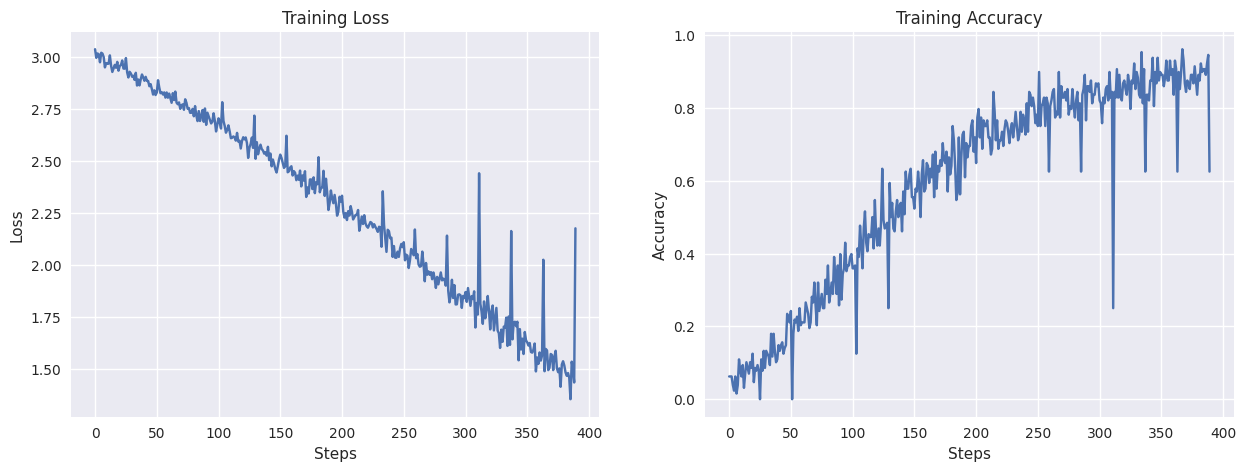

In [66]:
plt.figure(figsize = (15, 5))
plt.subplot(1,2,1)
plt.title('Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.plot(model.history['train_loss'])

plt.subplot(1,2,2)
plt.title('Training Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.plot(model.history['train_acc'])